# Classification Models with Crypto

In [71]:
# libraries
import pandas as pd
import random
from ta import add_all_ta_features
from datetime import datetime, timedelta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import plotly.express as px
from tqdm import tqdm
from eod_historical_data import get_eod_data
from sklearn.model_selection import GridSearchCV

# 1. Getting Crypto Price Data

In [28]:
# Importing and assigning the api key
with open("../eodHistoricalData-API.txt", "r") as f:
    api_key = f.read()
    

def getCryptoPrice(api_key, ticker="BTC-USD", n_days=1000):
    
    # Time periods
    now = datetime.now()

    # How far back to retrieve
    ago = now - timedelta(days=n_days)

    # Getting the price history for the crypto
    df = get_eod_data(
        ticker, 
        "CC", 
        api_key=api_key, 
        start=ago, 
        end=now
    )
    

    # Dropping a column
    df.drop(
        ["Adjusted_close"], 
        axis=1,
        inplace=True
    )

    return df

In [29]:
df = getCryptoPrice(api_key, ticker="BTC-USD", n_days=500)

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/eod_historical_data/data.py:41: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.



## Adding Technical Indicators

In [30]:
df = add_all_ta_features(
    df, 
    open="Open", 
    high="High", 
    low="Low", 
    close="Close", 
    volume="Volume", 
    fillna=True
)

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



# 2. Data Transformation/Preprocessing

In [84]:
def transformData(df, days=1):
    """
    Transforming data into X variables for training.  Uses percent change and 
    multiplies the percentage by 100 rounded to 2 decimal places.
    """
    # Transforming data
    new_df = df.pct_change(
        days
    ).apply(
        lambda x: round(x*100, 2)
    ).replace(
        [np.inf, -np.inf], 
        np.nan
    ).shift(1) # Compensating for indicator lookahead bias
    
    # Dropping Nans
    new_df = new_df.dropna(
        thresh=round(new_df.shape[1]*.7) # If 70% of the values in the row are Nans, drop the whole row
    ).dropna(
        axis=1,
        thresh=round(new_df.shape[0]*.7) # If 70% of the values in the columns are Nans, drop the whole column
    )
    
    # Determining percent change and setting it as -1, 0, and 1 as Sell, Do Nothing, and Buy respectively
    new_df['decision']= df['Open'].pct_change(
        days
    ).shift(
        -days
    ).apply(
        lambda x: x>0
    ).astype(float)
    
    # Saving the last value in the dataset for later
    last_val = new_df.tail(1).drop('decision',
                                   axis=1)

    # Dropping the last NaNs from the Y variable
    new_df = new_df.dropna(
        subset=['decision']
    )

    # Filling in the rest of the NaNs with the most recent value
    new_df = new_df.fillna(method='ffill').dropna()

    return new_df, last_val

In [85]:
n_df, last_val = transformData(df, days=1)

## Balance Data

In [86]:
def balanceDecisions(n_df):
    """
    Rebalances data so that each class/decision is represented equally.
    """
    # Counting each class or decision
    counts = n_df['decision'].value_counts()

    # The lowest number of represented classes
    low_num = counts.min()

    # Sampling from the DF
    df1 = n_df[n_df['decision']==counts.sort_values().index[0]].sample(low_num, random_state=11)

    df2 = n_df[n_df['decision']==counts.sort_values().index[1]].sample(low_num, random_state=11)

    # Combining the resampled DFs and returning it
    return df1.append(df2)

In [87]:
n_df = balanceDecisions(n_df)

# 3. Fitting to Classification Models

In [88]:
# Train, test, split
X = n_df.drop('decision', axis=1)

y = n_df['decision']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20
)

## Getting a Baseline Model
Using random choices

In [90]:
# Random predictions
ran_pred = random.choices([1,0], k=len(y_test))

#Printing out results
report = classification_report(y_test, ran_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.56      0.55      0.55        44
         1.0       0.51      0.53      0.52        40

    accuracy                           0.54        84
   macro avg       0.54      0.54      0.54        84
weighted avg       0.54      0.54      0.54        84



## Getting Classification Reports from Other Models

In [91]:
# Other models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

models = {
    "adaboost":AdaBoostClassifier(random_state=11), 
    "gradboost":GradientBoostingClassifier(random_state=11), 
    "rf":RandomForestClassifier(random_state=11), 
    "knn":KNeighborsClassifier(),
    "logreg":LogisticRegression(solver='liblinear'), 
    "nb":GaussianNB(), 
    "svm":SVC(),
    "dec_tree": DecisionTreeClassifier()
}

In [92]:
for model_name, model in models.items():
    
    # Fitting 
    clf = model
    
    clf.fit(X_train, y_train)
    
    # Predictions
    preds = clf.predict(X_test)

    #Printing out results
    report = classification_report(y_test, preds)
    print(model_name+"\n",report)

adaboost
               precision    recall  f1-score   support

         0.0       0.53      0.57      0.55        44
         1.0       0.49      0.45      0.47        40

    accuracy                           0.51        84
   macro avg       0.51      0.51      0.51        84
weighted avg       0.51      0.51      0.51        84

gradboost
               precision    recall  f1-score   support

         0.0       0.50      0.48      0.49        44
         1.0       0.45      0.47      0.46        40

    accuracy                           0.48        84
   macro avg       0.48      0.48      0.48        84
weighted avg       0.48      0.48      0.48        84

rf
               precision    recall  f1-score   support

         0.0       0.50      0.57      0.53        44
         1.0       0.44      0.38      0.41        40

    accuracy                           0.48        84
   macro avg       0.47      0.47      0.47        84
weighted avg       0.47      0.48      0.47      

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# 5. Backtesting Each Model

In [93]:
def fitModels(new_df, tuning=False):
    """
    From a list of models. Fit and trains them to the dataframe.
    Returns the fitted models.
    """
    # Models
    models = {
        "adaboost":AdaBoostClassifier(random_state=11), 
        "gradboost":GradientBoostingClassifier(random_state=11), 
        "randomforest":RandomForestClassifier(random_state=11), 
        "knn":KNeighborsClassifier(),
        "logreg":LogisticRegression(solver='liblinear'), 
        "naivebayes":GaussianNB(), 
        "svm":SVC(),
        "dectree": DecisionTreeClassifier()
    }
    
    # Model parameters (to be tuned if needed)
    params = {
        "adaboost": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [1.0, .1, .01]
        }, 
        "gradboost":{
            "n_estimators": [50, 100, 200],
            "learning_rate": [1.0, .1, .01]
        }, 
        "randomforest":{
            "n_estimators": [50, 100, 200],
            "criterion": ['gini', 'entropy']
        }, 
        "knn":{
            "n_neighbors": [5, 10, 20, 50]
        },
        "logreg":{
            "penalty": ["l1", "l2", "elasticnet", "none"]
        }, 
        "naivebayes":{}, 
        "svm":{
            "kernel": ["linear", "poly", "rbf", "sigmoid"]
        },
        "dectree": {
            "criterion": ['gini', 'entropy'],
            "splitter": ['best', "random"]
        }
    }
    
    # Fitted models
    fitted = {}
    
    # Variables
    X = new_df.drop('decision', axis=1)

    y = new_df['decision']
    
    # Fitting each model
    for model_name, model in models.items():

        # Instantiating model
        clf = model
        
        if tuning:
            
            # Grid searching the model if wanted
            clf = GridSearchCV(
                clf, 
                params[model_name], 
                verbose=3, 
                scoring='f1_macro'
            )

            clf.fit(X, y)
            
            clf = clf.best_estimator_
        
        else:
            clf.fit(X, y)
        
        # Adding each fitted model to the fitted dictionary
        fitted[model_name] = clf

    return fitted

In [94]:
def backtestModels(ticker, days_to_backtest, days_to_train, api_key):
    """
    Backtests multiple classification models based on the given crypto ticker. Range of 
    backtest is dependent on days_to_backtest. Training data is dependent on days_to_train.
    """

    # Getting Data 
    df = getCryptoPrice(
        api_key=api_key,
        ticker=ticker, 
        n_days=days_to_backtest+days_to_train
    )

    # Creating a DF for predictions
    pred_df = pd.DataFrame()

    # Iterating through the DF starting from the least amount of days to train on
    for i in tqdm(range(days_to_train, len(df)+1)):

        # Training DF
        train_df = df[i-days_to_train:i]

        # Tranforming the Training DF
        t_df, last_val = transformData(train_df)
        
        # Rebalancing the data
        t_df = balanceDecisions(t_df)

        # Fitting models
        fitted_models = fitModels(t_df)
        
        # Setting the new index to classify
        pred = pd.DataFrame(index=last_val.index+pd.offsets.Day(1))

        # Making classifications for the very next day
        for model_name, model in fitted_models.items():
                        
            pred[model_name] = model.predict(last_val)

        # Appending the classifications to the dataframe
        pred_df = pred_df.append(pred)
        
    # Random strategy
    pred_df['random_predict'] = random.choices([1,0], k=len(pred_df))
        
    # The Buy and Hold Strategy
    pred_df['buy_hold'] = 1

    # Getting log returns from the original DF
    log_returns = df['Open'].tail(len(pred_df)).apply(np.log).diff()
    
    # Dropping any Nans and compensating for lookahead bias
    pred_df = pred_df.shift(1).dropna()

    # Performing the backtest
    returns = pred_df.multiply(log_returns, axis=0)
    
    # Inversing the log returns and getting daily portfolio balance
    performance = returns.cumsum().apply(np.exp)
    
    return performance

## Running the Backtest

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/eod_historical_data/data.py:41: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.

100%|██████████| 367/367 [00:38<00:00,  9.41it/s]


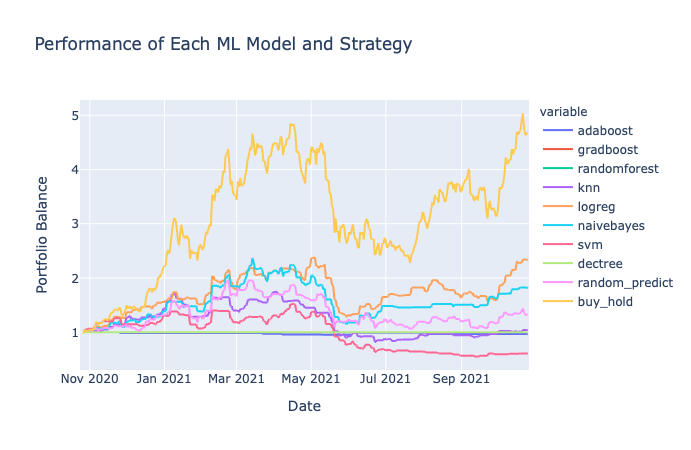

In [96]:
# API Key
with open("../eodHistoricalData-API.txt", "r") as f:
    api_key = f.read()

# Backtest performance
performance = backtestModels("BTC-USD", 365, 100, api_key)

# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='Performance of Each ML Model and Strategy',
    labels={"value": "Portfolio Balance",
            "ds": "Date"}
)

fig.show()

## Backtesting with Different Training Sizes

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/eod_historical_data/data.py:41: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.

100%|██████████| 367/367 [00:47<00:00,  7.79it/s]


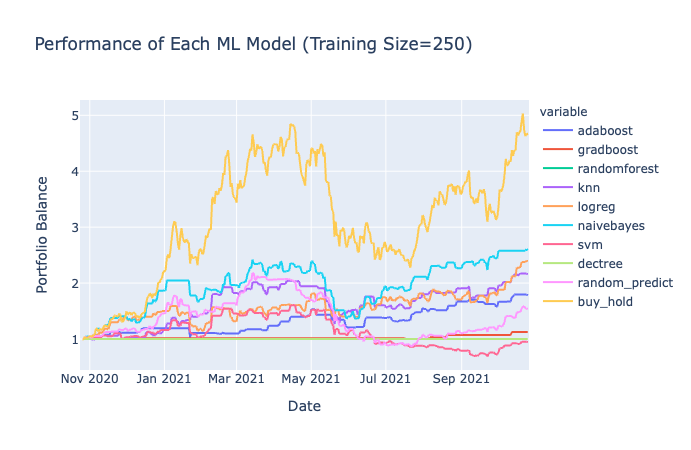

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/eod_historical_data/data.py:41: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.

100%|██████████| 367/367 [01:04<00:00,  5.70it/s]


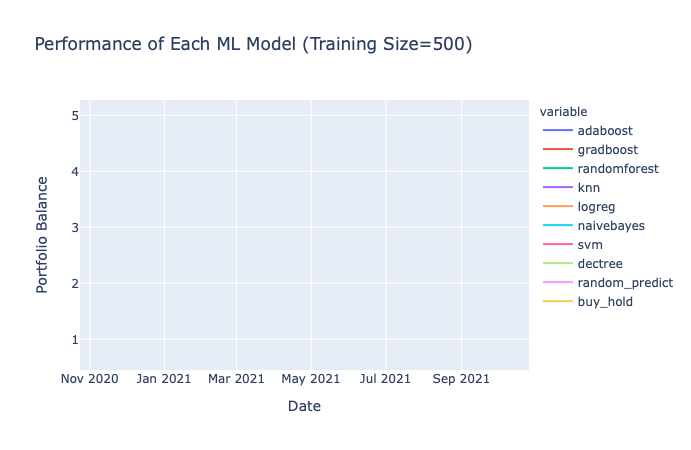

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/eod_historical_data/data.py:41: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.

100%|██████████| 367/367 [01:25<00:00,  4.28it/s]


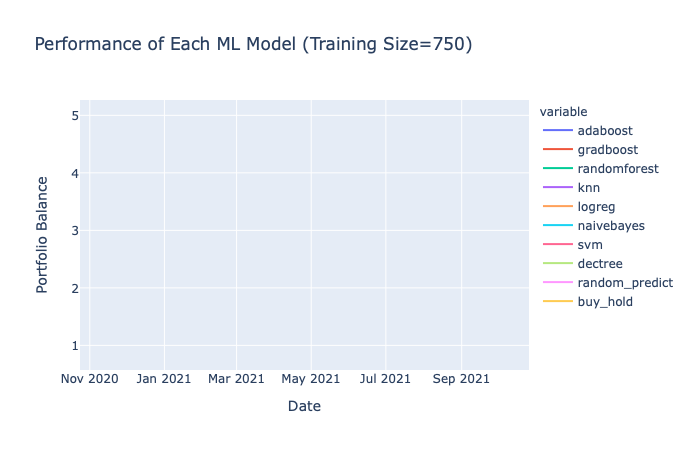

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/eod_historical_data/data.py:41: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.

100%|██████████| 367/367 [01:45<00:00,  3.49it/s]


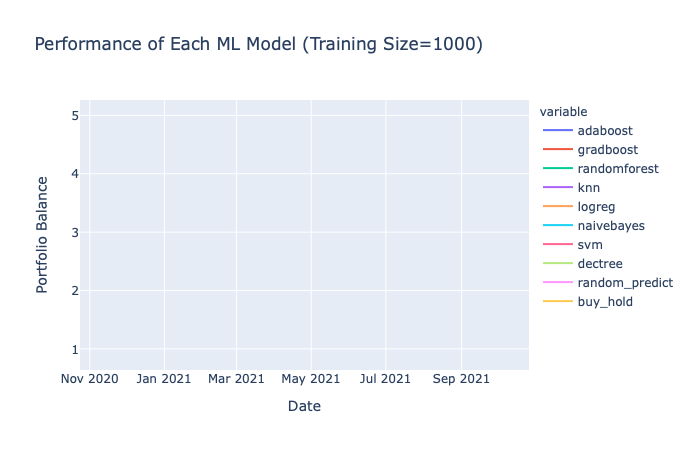

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/eod_historical_data/data.py:41: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.

100%|██████████| 367/367 [02:08<00:00,  2.86it/s]


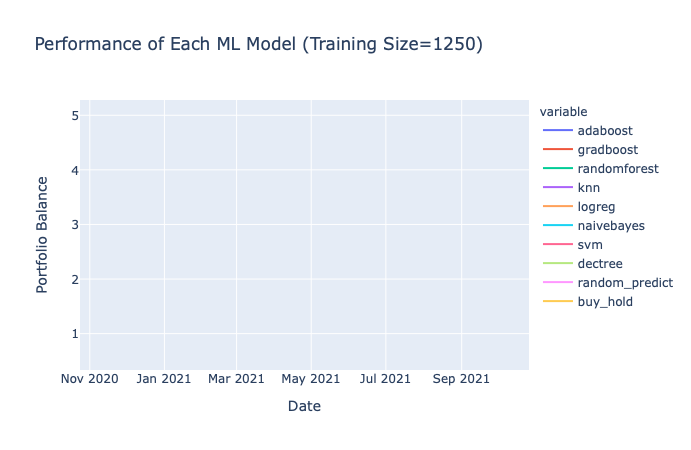

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/eod_historical_data/data.py:41: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.

100%|██████████| 367/367 [02:29<00:00,  2.46it/s]


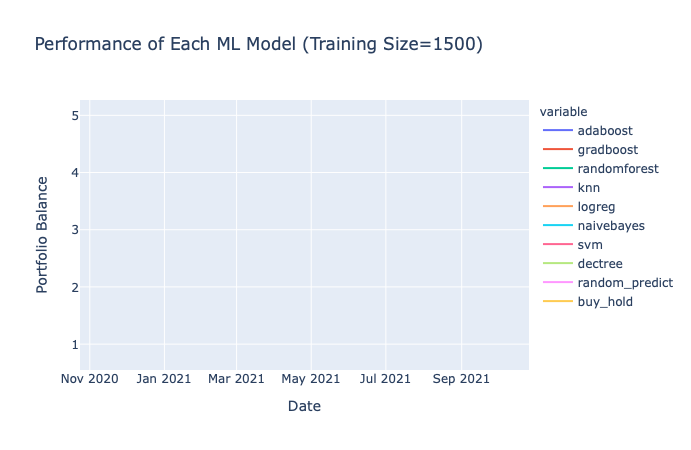

In [97]:
# Experimenting with different training sizes
for i in range(250, 1750, 250):
    
    # Backtest performance
    performance = backtestModels("BTC-USD", 365, i, api_key)

    # Visualizing results
    fig = px.line(
        performance,
        x=performance.index,
        y=performance.columns,
        title=f'Performance of Each ML Model (Training Size={i})',
        labels={"value": "Portfolio Balance",
                "ds": "Date"}
    )

    fig.show()